# Object Counting

Gargeya Sharma - 220278025 - MSc Artificial intelligence

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["image.cmap"] = 'gray'

from tqdm.notebook import tqdm_notebook as tq
from skimage import measure


In [2]:
def ICV_convert_to_gray(image):
    image = (0.3*image[:,:,0]+0.59*image[:,:,1]+0.11*image[:,:,2])/3
    return image

In [3]:
import cv2
cap = cv2.VideoCapture("../Dataset/DatasetC.mpg")

frames = []
while (cap.isOpened()):
    # Read a new frame

    ret, frame = cap.read()
    if ret == True:
        frame = np.array(frame)
        frame = ICV_convert_to_gray(frame)
        frames.append(frame)
    else:
        break
frames = np.array(frames)
cap.release()

In [4]:
frames.shape

(140, 288, 352)

# a)

Experimenting with different threshold values and getting a balanced value between **level of noise in the image** and **portraying the object with as many 255 pixel values as we can (To get a holistic representation of the object)**

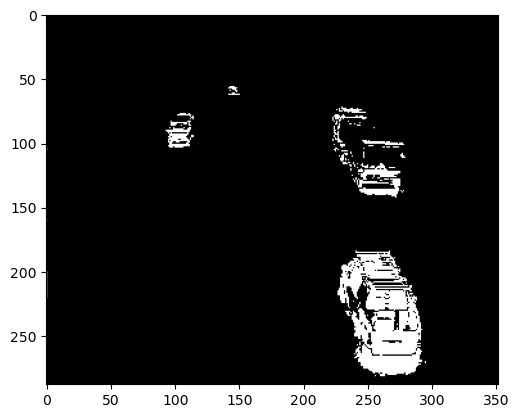

In [5]:
plt.imshow((abs(frames[0]-frames[1])>8.5).astype(int)*255)

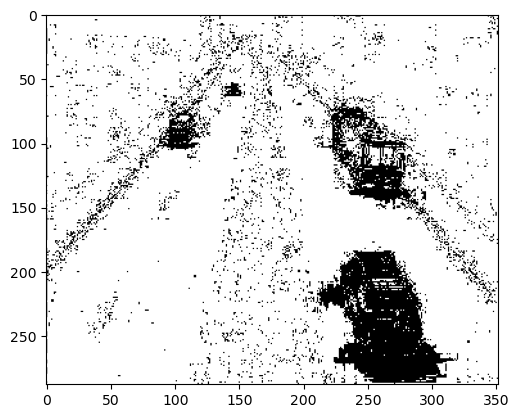

In [6]:
plt.imshow((abs(frames[0]-frames[1])<2).astype(int)*255)

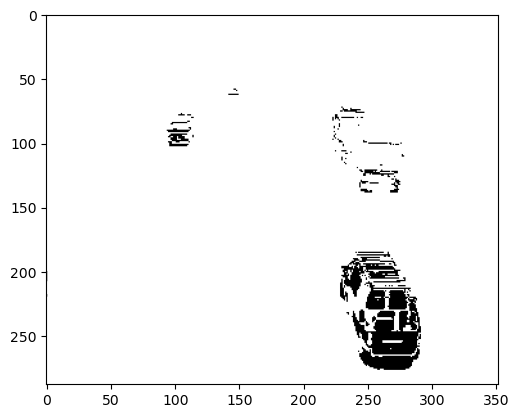

In [7]:
plt.imshow((abs(frames[0]-frames[1])<15).astype(int)*255)

In [8]:
def ICV_pbp_diff(frames):
    diff = []
    threshold = 9.5
    frame1 = frames[0]
    for i in frames[1:]:
        d = (abs(frame1 - i)>threshold).astype(int)*255
        diff.append(d)
    return np.array(diff)

In [9]:
first_frame_ref = ICV_pbp_diff(frames)
first_frame_ref.shape

(139, 288, 352)

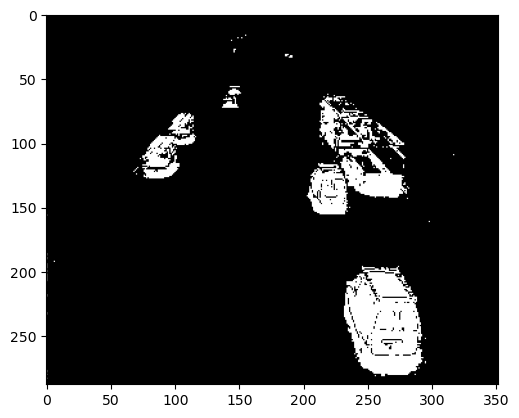

In [10]:
plt.imshow(first_frame_ref[10])

# b.)

In [11]:
def ICV_pbp_prev_next_diff(frames):
    diff = []
    threshold = 7.5
    for i in range(frames.shape[0]-1):
        prev = frames[i]
        nex = frames[i+1]
        d = (abs(prev - nex)>threshold).astype(int)*255
        diff.append(d)
    return np.array(diff)

In [12]:
prev_next = ICV_pbp_prev_next_diff(frames)
prev_next.shape

(139, 288, 352)

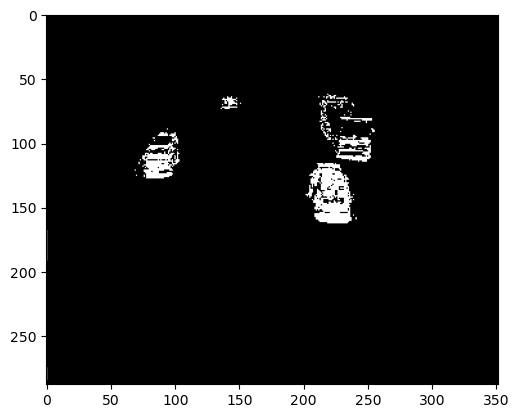

In [13]:
plt.imshow(prev_next[10])

# c.)

In [14]:
def ICV_get_ref_frame(frames):
    diff = []
    threshold = 12
    for i in range(frames.shape[0]-1):
        prev = frames[i]
        nex = frames[i+1]
        d = (abs(prev - nex)<threshold).astype(int)
        d = d*nex
        diff.append(d)
        out = np.average(np.array(diff), axis=0).astype(int)
    return out

In [15]:
temp = ICV_get_ref_frame(frames)

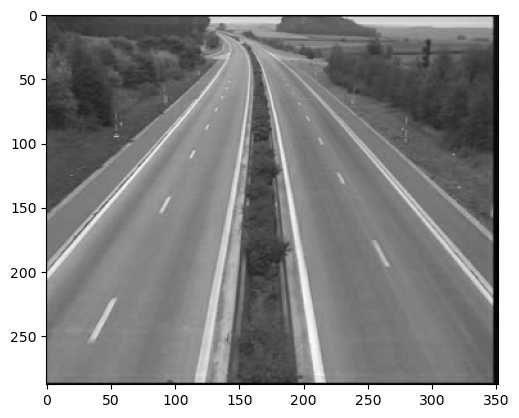

In [16]:
plt.imshow(temp)

### Experimentation with another approach
> Using Median for getting the reference frame from the collections of frames

In [17]:
def get_ref_framev2(frames):
    diff = np.median(frames, axis=0).astype(int)
    return np.array(diff)

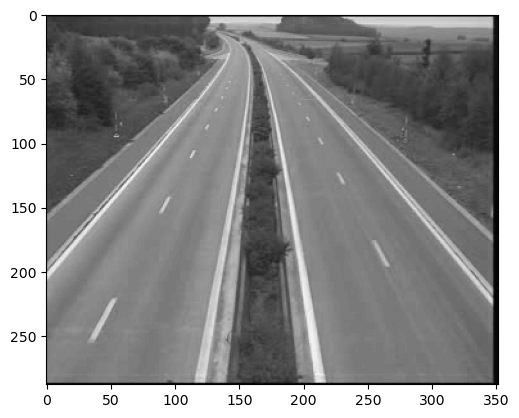

In [18]:
tempv2 = get_ref_framev2(frames)
plt.imshow(tempv2)

In [19]:
def ICV_pbp_diff_with_ref_frame(ref_frame, frames):
    diff = []
    threshold = 11
    for i in frames[1:]:
        d = ((ref_frame - i)>threshold).astype(int)*255
        diff.append(d)
    return np.array(diff)

In [20]:
output = ICV_pbp_diff_with_ref_frame(temp, frames)

In [21]:
output.shape

(139, 288, 352)

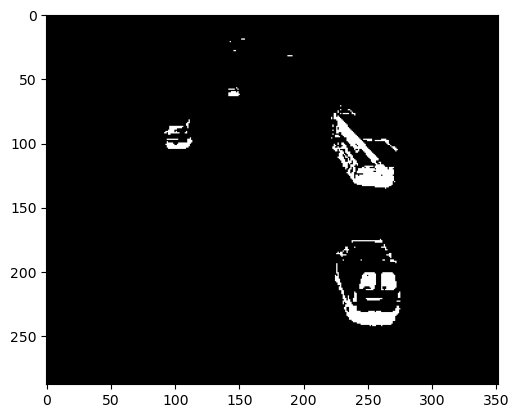

In [22]:
plt.imshow(output[1])

In [23]:
def ICV_zero_pad(window, pad=1):
    dimy, dimx = window.shape
    temp = np.vstack((np.zeros((pad,dimx)), window, np.zeros((pad,dimx))))
    temp = np.hstack((np.zeros((dimy+2*pad,pad)), temp, np.zeros((dimy+2*pad,pad))))
    return temp

ICV_zero_pad(np.ones((5,5)), pad=2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [24]:
def NN(img, window=10):
    # Nearest neighbor approach to fill the holes in object masks
    image = np.zeros_like(img)
    img = ICV_zero_pad(img, pad=int(window/2))
    for i in range(img.shape[0]-window):
        for j in range(img.shape[1]-window):
            neighbors = img[i:i+window, j:j+window]
            
            x = 1 if np.sum(neighbors)>=(window**2)-1 else 0
            image[i, j] = x
    return image


def Fine_NN(img, window=7):
    # Nearest neighbor approach to give the object masks more defined shape
    image = np.zeros_like(img)
    img = ICV_zero_pad(img, pad=int(window/2))
    for i in range(img.shape[0]-window):
        for j in range(img.shape[1]-window):
            neighbors = img[i:i+window, j:j+window]
                    
            x = np.max(neighbors)
            
            image[i, j] = x
    return image


out = NN(output[100])
out = Fine_NN(out)

out.shape

(288, 352)

(288, 352)


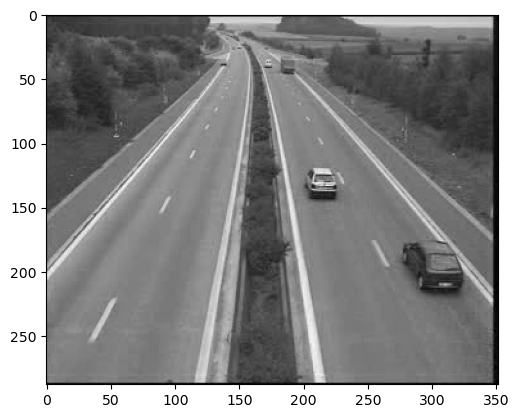

In [25]:
print(frames[101].shape)
plt.imshow(frames[101])

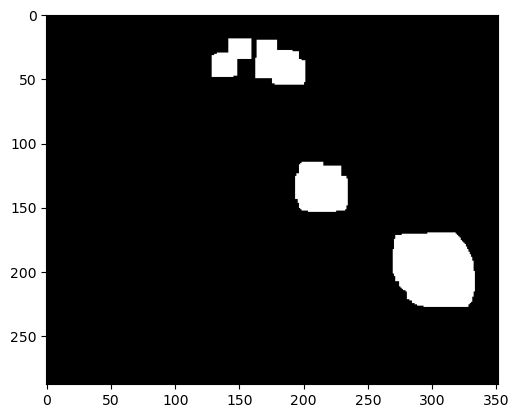

In [26]:
plt.imshow(out)

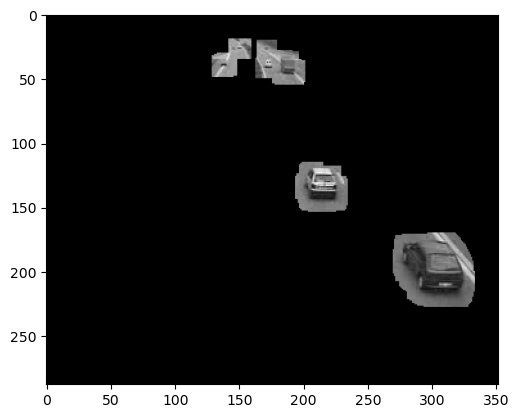

In [27]:
plt.imshow(frames[101]*out)

In [28]:
## Row scanning used to check when the value are changing from 0->1 or 1->0 and because that defines that 
## something is encapsulated within those changes, true, false values are summed and divided by 2 to get the number of objects in that row. 
## Also if in the next row number of objects changes than we can expect another object/s in furhter rows so there is a if else condition to check that.

def ICV_count_object(out):
    count = 0
    track = []
    for i in range(out.shape[0]):
        label = []
        for j in range(out.shape[1]-1):
            label.append(out[i,j] != out[i,j+1])
        l = sum(label)//2
        track.append(l)
        if count == 0:
            count += l
        else:
            if track[-1] > track[-2]:
                count += (track[-1]-track[-2])
    return count

In [29]:
def ICV_Mask_Object_Video(frames):
    result = []
    hist_result = []
    temp = ICV_get_ref_frame(frames)
    output = ICV_pbp_diff_with_ref_frame(temp, frames)
    for frame in tq(output):
        out = NN(frame)
        out = Fine_NN(out)
        result.append(out)
        count = ICV_count_object(out)
        hist_result.append(count)
    return np.array(result), np.array(hist_result)

In [30]:
result, histogram = ICV_Mask_Object_Video(frames)

  0%|          | 0/139 [00:00<?, ?it/s]

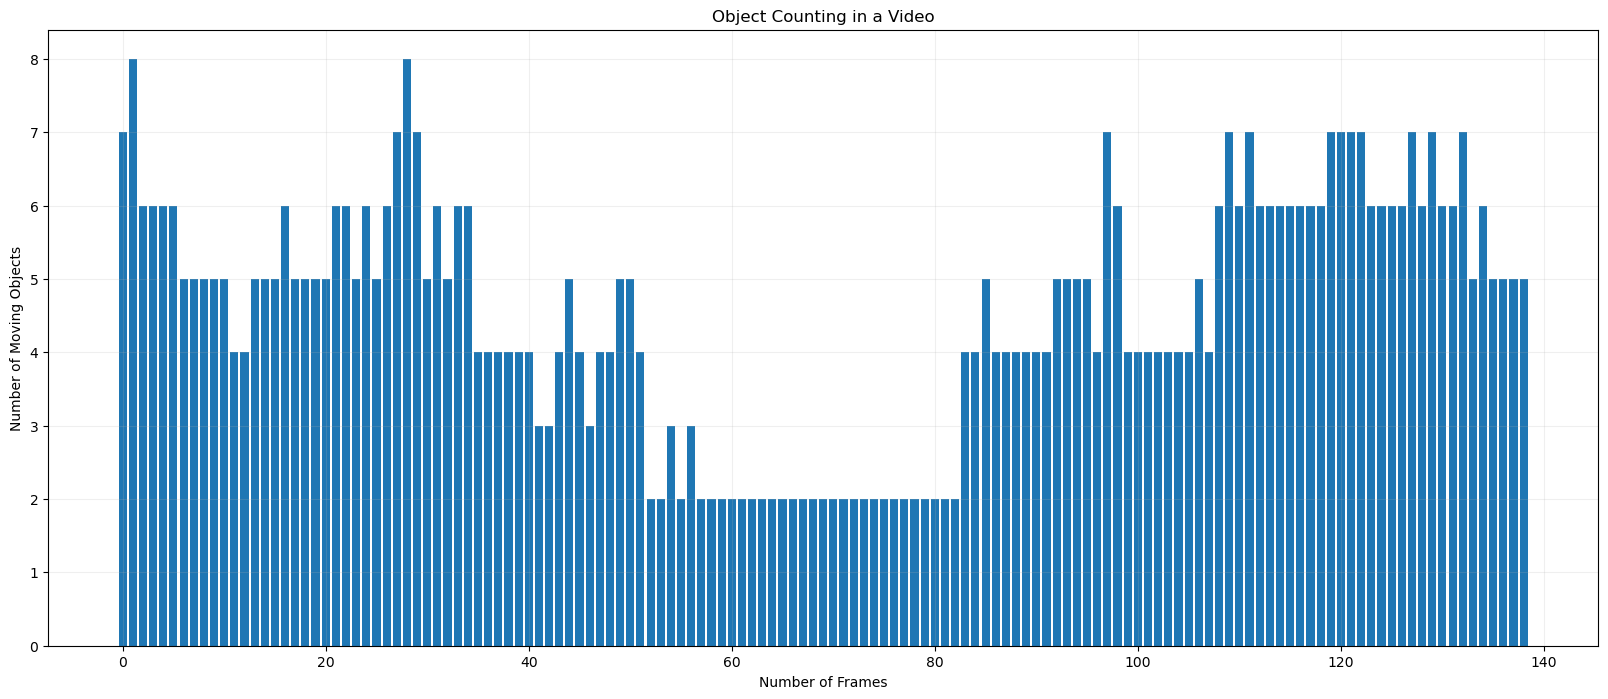

In [31]:
plt.figure(figsize=(20,8))
plt.bar(list(range(len(histogram))), histogram)
plt.xlabel("Number of Frames")
plt.ylabel("Number of Moving Objects")
plt.title("Object Counting in a Video")
plt.grid(True, alpha=0.2)
plt.show()

### Critical Analysis by testing my maskings with Skimage.measure method
(Ignore if its irrelevant to your evalutaion)

In [32]:
def ICV_Mask_Object_Video(frames):
    result = []
    hist_result = []
    temp = ICV_get_ref_frame(frames)
    output = ICV_pbp_diff_with_ref_frame(temp, frames)
    for frame in tq(output):
        out = NN(frame)
        out = Fine_NN(out)
        result.append(out)
        labels = measure.label(out)
        hist_result.append(labels.max())
    return np.array(result), np.array(hist_result)

In [33]:
result, histogram = ICV_Mask_Object_Video(frames)

  0%|          | 0/139 [00:00<?, ?it/s]

In [34]:
len(histogram)

139

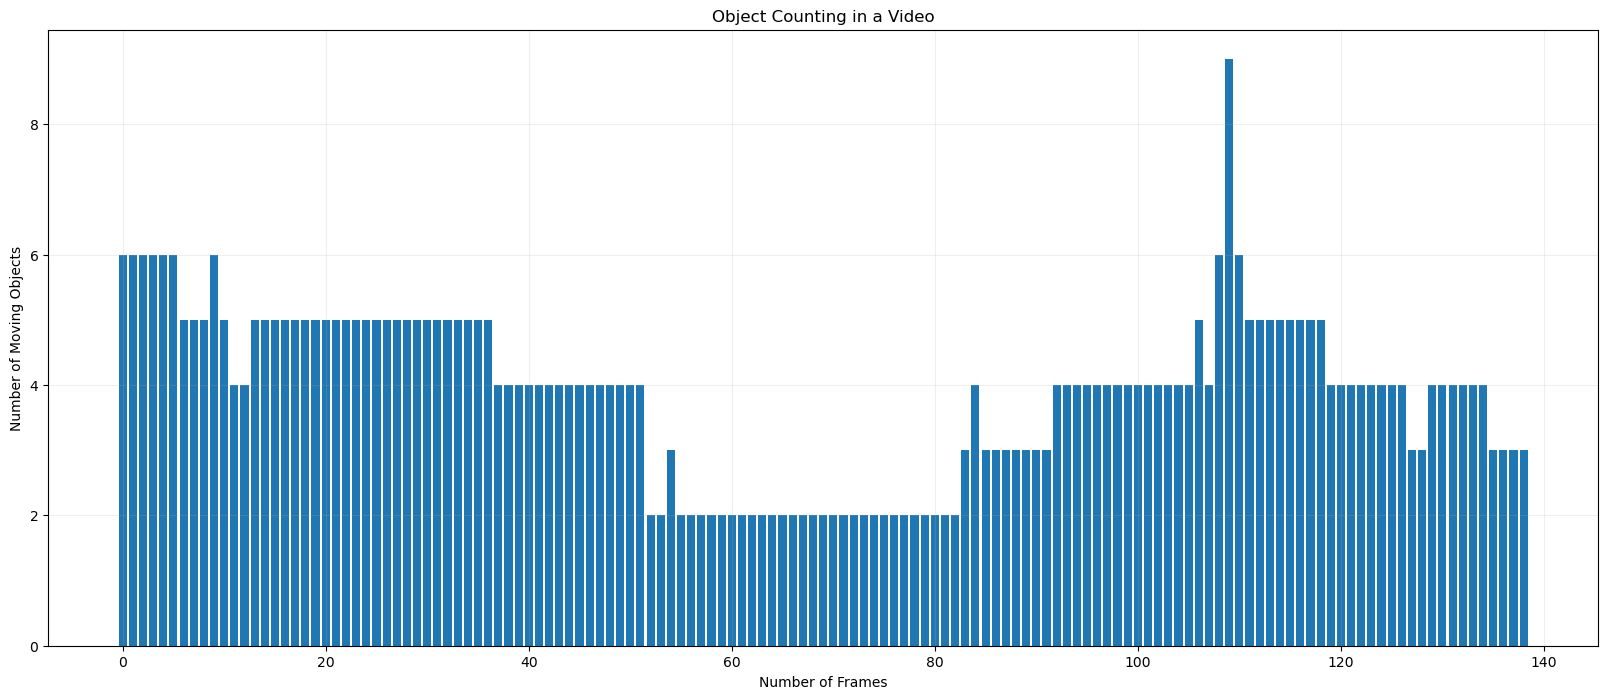

In [35]:
plt.figure(figsize=(20,8))
plt.bar(list(range(len(histogram))), histogram)
plt.xlabel("Number of Frames")
plt.ylabel("Number of Moving Objects")
plt.title("Object Counting in a Video")
plt.grid(True, alpha=0.2)
plt.show()

---